Run original HMM of trace and spike. Compare the decoded error.

In [1]:
import sys
sys.path.append('/Users/daiyiluo/Documents/ELEC599')
import CalHMM
import numpy as np
import matplotlib.pyplot as plt
import hmmlearn.hmm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import imp
imp.reload(CalHMM)

## Load data

In [2]:
folder = '/Users/daiyiluo/Downloads/KQ095_210205' #KQ086_210110' #
timebin = 500

In [3]:
data = np.load(f'{folder}/timebin_{timebin}.npz') #{folder}/timebin_500.npz
Distance = data['Distance']
lap_end = data['lap_end']
idx = data['idx']

Spike = np.load(f'{folder}/timebin_{timebin}_spks.npy')
Trace = data['Trace']

del data

Spike.shape, Trace.shape, Distance.shape, idx.shape

((1821, 219), (1821, 219), (1821,), (1821,))

## Run HMM

In [5]:
origin1 = hmmlearn.hmm.GaussianHMM(n_components=20) 
origin1.fit(Trace)
x1, plst1, occ1, posterior_states1, pos_COM1 = CalHMM.comp_poststates_pos(origin1, Trace, Distance)
err_rate1, dev1, Decoded_position1 = CalHMM.comp_decoded_pos_acc(Distance, posterior_states1, pos_COM1)

In [7]:
origin2 = hmmlearn.hmm.PoissonHMM(n_components=20) 
origin2.fit(Spike)
x2, plst2, occ2, posterior_states2, pos_COM2 = CalHMM.comp_poststates_pos(origin2, Spike, Distance)
err_rate2, dev2, Decoded_position2 = CalHMM.comp_decoded_pos_acc(Distance, posterior_states2, pos_COM2)

## Plots

In [8]:
d = np.unique(Distance)
m=d[1]+d[-1]
theta = 2*np.pi*Distance/m
t_st=0
t_duration=len(Distance)
lap_end0 = lap_end - t_st

theta_dc1 = 2*np.pi*Decoded_position1/m
error1 = np.arccos(np.cos(theta - theta_dc1))

theta_dc2 = 2*np.pi*Decoded_position2/m
error2 = np.arccos(np.cos(theta - theta_dc2))

(200.0, 500.0)

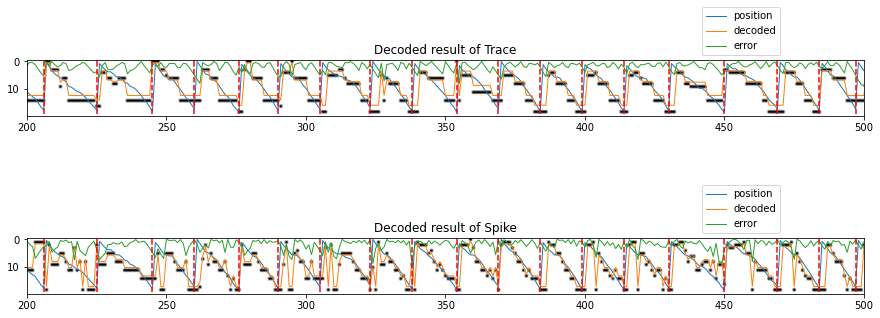

In [18]:
fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(2,1,1)
ax1.imshow(-posterior_states1[t_st:t_st+t_duration,plst1].T, cmap = 'gray')
ax1.plot(Distance[t_st:t_st+t_duration]*10,label='position',linewidth=1)
ax1.plot(Decoded_position1[t_st:t_st+t_duration]*10,label='decoded',linewidth=1)
ax1.plot(error1*m/(2*np.pi)*10,label='error',linewidth=1)
num = np.where((lap_end>t_st)&(lap_end<t_st+t_duration))[0]
for i in num:
    ax1.plot([lap_end0[i],lap_end0[i]],[0,plst1.size-1], 'r--')
plt.legend(bbox_to_anchor=(.8, 1))
plt.title('Decoded result of Trace')

ax2 = fig.add_subplot(2,1,2, sharex=ax1)
ax2.imshow(-posterior_states2[t_st:t_st+t_duration,plst2].T, cmap = 'gray')
ax2.plot(Distance[t_st:t_st+t_duration]*10,label='position',linewidth=1)
ax2.plot(Decoded_position2[t_st:t_st+t_duration]*10,label='decoded',linewidth=1)
ax2.plot(error2*m/(2*np.pi)*10,label='error',linewidth=1)
num = np.where((lap_end>t_st)&(lap_end<t_st+t_duration))[0]
for i in num:
    ax2.plot([lap_end0[i],lap_end0[i]],[0,plst2.size-1], 'r--')
plt.legend(bbox_to_anchor=(.8, 1))
plt.title('Decoded result of Spike')

plt.xlim(200,500)

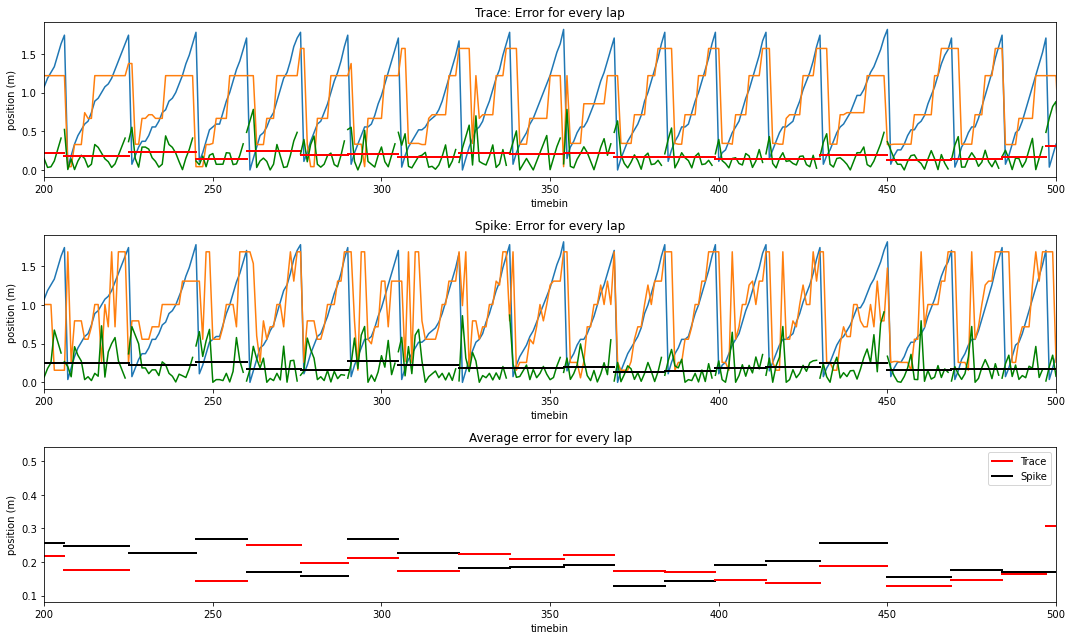

In [39]:
er_pos1 = error1*m/(2*np.pi)
er_lap1 = np.zeros(len(num))

er_pos2 = error2*m/(2*np.pi)
er_lap2 = np.zeros(len(num))

fig = plt.figure(figsize=(15,9))

ax1 = fig.add_subplot(3,1,1)
ax1.plot(Distance)
ax1.plot(Decoded_position1)
for i in num:
    seg=er_pos1[lap_end0[i-1]:lap_end0[i]]
    er_lap1[i-1]=np.mean(seg)
    ax1.plot(np.arange(lap_end0[i-1],lap_end0[i]),seg,'g')
    ax1.plot([lap_end0[i-1],lap_end0[i]],[er_lap1[i-1],er_lap1[i-1]],'r', linewidth=2)
ax1.set_title('Trace: Error for every lap')
ax1.set_xlabel('timebin')
ax1.set_ylabel('position (m)')
    
ax2 = fig.add_subplot(3,1,2, sharex=ax1)
ax2.plot(Distance)
ax2.plot(Decoded_position2)
for i in num:
    seg=er_pos2[lap_end0[i-1]:lap_end0[i]]
    er_lap2[i-1]=np.mean(seg)
    ax2.plot(np.arange(lap_end0[i-1],lap_end0[i]),seg,'g')
    ax2.plot([lap_end0[i-1],lap_end0[i]],[er_lap2[i-1],er_lap2[i-1]],'k', linewidth=2)
ax2.set_title('Spike: Error for every lap')
ax2.set_xlabel('timebin')
ax2.set_ylabel('position (m)')

ax3 = fig.add_subplot(3,1,3, sharex=ax1)
for i in num[:-1]:
    seg=er_pos1[lap_end0[i-1]:lap_end0[i]]
    er_lap1[i-1]=np.mean(seg)
    ax3.plot([lap_end0[i-1],lap_end0[i]],[er_lap1[i-1],er_lap1[i-1]],'r', linewidth=2)
    seg=er_pos2[lap_end0[i-1]:lap_end0[i]]
    er_lap2[i-1]=np.mean(seg)
    ax3.plot([lap_end0[i-1],lap_end0[i]],[er_lap2[i-1],er_lap2[i-1]],'k', linewidth=2)
i=num[-1]
seg=er_pos1[lap_end0[i-1]:lap_end0[i]]
er_lap1[i-1]=np.mean(seg)
ax3.plot([lap_end0[i-1],lap_end0[i]],[er_lap1[i-1],er_lap1[i-1]],'r',label='Trace', linewidth=2)
seg=er_pos2[lap_end0[i-1]:lap_end0[i]]
er_lap2[i-1]=np.mean(seg)
ax3.plot([lap_end0[i-1],lap_end0[i]],[er_lap2[i-1],er_lap2[i-1]],'k',label='Spike', linewidth=2)
ax3.set_title('Average error for every lap')
ax3.set_xlabel('timebin')
ax3.set_ylabel('position (m)')

plt.xlim(200,500)
plt.legend()
plt.tight_layout()

Text(0.5, 1.0, 'Average error for every lap')

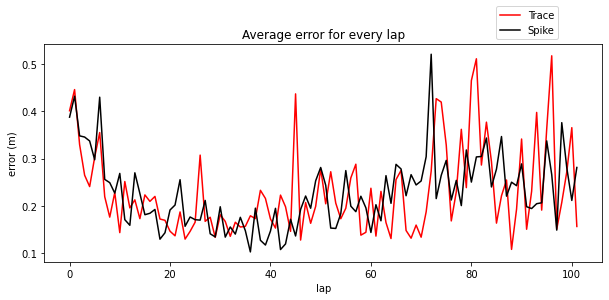

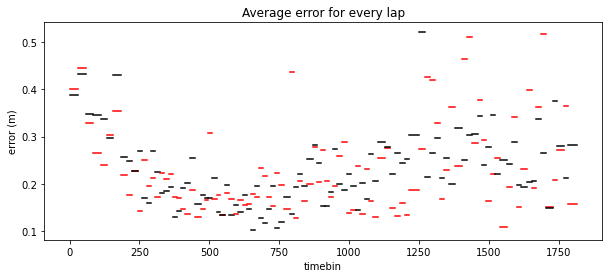

In [41]:
fig = plt.figure(figsize=(10,4))

plt.plot(er_lap1, 'r', label='Trace')
plt.plot(er_lap2, 'k', label='Spike')
plt.xlabel('lap')
plt.ylabel('error (m)')
plt.title('Average error for every lap')
    
plt.legend(bbox_to_anchor=(.8, 1))

plt.figure(figsize=(10,4))
for i in num:
    seg=er_pos1[lap_end0[i-1]:lap_end0[i]]
    er_lap1[i-1]=np.mean(seg)
    plt.plot([lap_end0[i-1],lap_end0[i]],[er_lap1[i-1],er_lap1[i-1]],'r')
    seg=er_pos2[lap_end0[i-1]:lap_end0[i]]
    er_lap2[i-1]=np.mean(seg)
    plt.plot([lap_end0[i-1],lap_end0[i]],[er_lap2[i-1],er_lap2[i-1]],'k')
plt.xlabel('timebin')
plt.ylabel('error (m)')
plt.title('Average error for every lap')